# Building a CNN to detect abnormalities on X-ray images (MURA dataset)

## Description of the dataset
MURA (musculoskeletal radiographs) is a large dataset of bone X-rays. Algorithms are tasked with determining whether an X-ray study is normal or abnormal.


The data is split into categories determined by one of the following types of scans:
   * XR_ELBOW
   * XR_FINGER
   * XR_FOREARM
   * XR_HAND
   * XR_HUMERUS
   * XR_SHOULDER
   * XR_WRIST
    
    
It is further split according to the patients' ID and then the specific study performed on said patient.
Each study can contain one or more images of the X-ray scan, which are lebaled either as positive or negative, depending on the existence of an abnormality in the musculoskeletal region.

## Imports

In [97]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from sklearn.metrics import roc_curve, auc

import cv2
import matplotlib.pyplot as plt

import time

## Constants

In [98]:
# files
TRAIN_PATHS = 'MURA-v1.1/train_image_paths.csv'
TRAIN_LABELS = 'MURA-v1.1/train_labeled_studies.csv'
VALID_PATHS = 'MURA-v1.1/valid_image_paths.csv'
VALID_LABELS = 'MURA-v1.1/valid_labeled_studies.csv'

RAND_SEED = 333
SAVE_MODEL = True # constant to stop accidentally loading images again
SAVE_DN169 = True # constant to stop accidentally re-training model

## Data preprocessing

In [99]:
train_paths_df = pd.read_csv(TRAIN_PATHS, header=None, names=['Path'])
train_labels_df = pd.read_csv(TRAIN_LABELS, header=None, names=['Study', 'Abnormal'])
valid_paths_df = pd.read_csv(VALID_PATHS, header=None, names=['Path'])
valid_labels_df = pd.read_csv(VALID_LABELS, header=None, names=['Study', 'Abnormal'])

In order to simplify the problem and the CNN architecture for now, I have reduced the number of images per study to just one

In [100]:
pd.set_option('display.max_colwidth', None)
reduced_train_paths_df = train_paths_df.loc[train_paths_df.Path.str.contains('.*image1.png')]
reduced_valid_paths_df = valid_paths_df.loc[valid_paths_df.Path.str.contains('.*image1.png')]
display(reduced_valid_paths_df)

,Path
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image1.png
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/image1.png
6,MURA-v1.1/valid/XR_WRIST/patient11186/study2_positive/image1.png
9,MURA-v1.1/valid/XR_WRIST/patient11186/study3_positive/image1.png
12,MURA-v1.1/valid/XR_WRIST/patient11187/study1_positive/image1.png
...,...
3185,MURA-v1.1/valid/XR_FINGER/patient11965/study1_negative/image1.png
3186,MURA-v1.1/valid/XR_FINGER/patient11855/study1_negative/image1.png
3187,MURA-v1.1/valid/XR_FINGER/patient11966/study1_negative/image1.png
3190,MURA-v1.1/valid/XR_FINGER/patient11967/study1_negative/image1.png


Loading the image data into a list so that I can further process it

In [101]:
start = time.time()

train_images = []
for index, row in reduced_train_paths_df.iterrows():
    train_images.append(cv2.imread(row.Path))

valid_images = []
for index, row in reduced_valid_paths_df.iterrows():
    valid_images.append(cv2.imread(row.Path))

print(f'{time.time() - start} sec')

137.5994439125061 sec


In [104]:
# backup save of train and validation set
t_backup = train_images
v_backup = valid_images

Example plot of some of the data

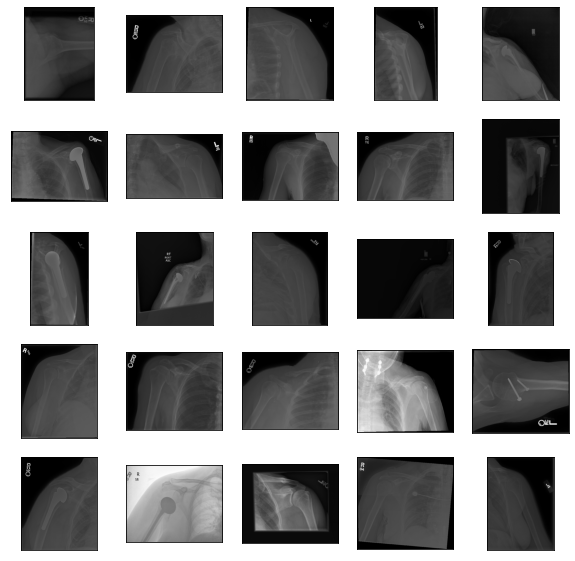

In [105]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
plt.show()

Based on the MURA baseline and the paper published along with it, I will resize all images to 320 x 320 pixels in order to have consisent inputs for the CNN

In [106]:
# resize images
for i in range(len(train_images)):
    train_images[i] = cv2.resize(train_images[i], (320, 320))

for i in range(len(valid_images)):
    valid_images[i] = cv2.resize(valid_images[i], (320, 320))

In [107]:
train_images = np.array(train_images)
valid_images = np.array(valid_images)

In [108]:
# check train and validation set sizes
print(train_images.shape)
print(train_labels_df.shape)
print(valid_images.shape)
print(valid_labels_df.shape)

(13457, 320, 320, 3)
(13457, 2)
(1199, 320, 320, 3)
(1199, 2)


## Build model

In [121]:
np.random.seed(RAND_SEED)
tf.random.set_seed(RAND_SEED)

Setup convolutional base with 3 x 3 feature filters (number of filters increases as input sizes get smaller)

MaxPooling 2 x 2 filter to reduce feature sizes

In [122]:
model = models.Sequential()
model.add(layers.Conv2D(24, (3, 3), padding='same', activation='relu', input_shape=(320, 320, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Classify image based on extracted features by first flattening the feature vector, then fully connecting to dense layer of 64 neurons and finally connecting those to the output neuron

In [123]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

In [124]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 320, 320, 24)      672       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 160, 160, 24)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 158, 158, 32)      6944      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 77, 77, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 36, 36, 64)       

## Train model

In [126]:
train_labels = np.array(train_labels_df.Abnormal.tolist())
valid_labels = np.array(valid_labels_df.Abnormal.tolist())

np.reshape(train_images, [-1, 320, 320, 3])
np.reshape(valid_images, [-1, 320, 320, 3])

model.compile(optimizer='adam',
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=['accuracy'])
    
history = model.fit(x=train_images, y=train_labels, epochs=5, validation_data=(valid_images, valid_labels), verbose=2)

Train on 13457 samples, validate on 1199 samples
Epoch 1/5
13457/13457 - 340s - loss: 5.9341 - accuracy: 0.6153 - val_loss: 6.9213 - val_accuracy: 0.5513
Epoch 2/5
13457/13457 - 334s - loss: 5.9341 - accuracy: 0.6153 - val_loss: 6.9213 - val_accuracy: 0.5513
Epoch 3/5
13457/13457 - 351s - loss: 5.9341 - accuracy: 0.6153 - val_loss: 6.9213 - val_accuracy: 0.5513
Epoch 4/5
13457/13457 - 348s - loss: 5.9341 - accuracy: 0.6153 - val_loss: 6.9213 - val_accuracy: 0.5513
Epoch 5/5
13457/13457 - 356s - loss: 5.9341 - accuracy: 0.6153 - val_loss: 6.9213 - val_accuracy: 0.5513


loss: 5.9341 - accuracy: 0.6153 - val_loss: 6.9213 - val_accuracy: 0.5513

## Test model

In [127]:
preds = model.predict(valid_images, verbose=1)

1199/1199 [==============================] - 11s 9ms/sample


In [128]:
valid_loss, valid_acc = model.evaluate(valid_images, valid_labels, verbose=1)

1199/1199 [==============================] - 10s 8ms/sample - loss: 6.9213 - accuracy: 0.5513


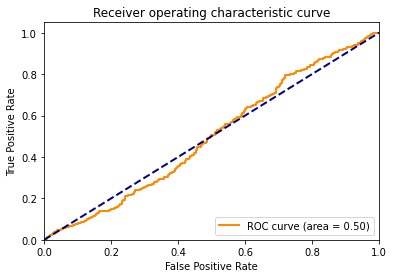

In [129]:
fpr, tpr, _ = roc_curve(valid_labels, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

In [130]:
if SAVE_MODEL:
    model.save('mura_basic_model.h5')

# -----------------------------------------------------------------------------------------------------------

# Preloading the DenseNet169 architecture and testing it on MURA

The Stanford baseline uses the DenseNet169 architecture as the convolutional base of its model, so I will attempt to load it and use it as well

## Load convolutional base

In [109]:
base_model = tf.keras.applications.DenseNet169(
    include_top=False, weights='imagenet', input_tensor=None, input_shape=None,
    pooling=None, classes=1000
)

base_model.trainable = False # freeze base

## Create classifier and merge models

Picks global averages from the pool of features

In [110]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

Output layer

In [111]:
prediction_layer = tf.keras.layers.Dense(1)

In [112]:
densenet_model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

In [113]:
densenet_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Model)          (None, None, None, 1664)  12642880  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1664)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1665      
Total params: 12,644,545
Trainable params: 1,665
Non-trainable params: 12,642,880
_________________________________________________________________


## Train model

In [114]:
base_learning_rate = 0.0001

densenet_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

See how evaluating the model goes before even training it

In [115]:
initial_epochs = 3

loss0, accuracy0 = densenet_model.evaluate(valid_images, valid_labels)

1199/1199 [==============================] - 245s 204ms/sample - loss: 1.2905 - accuracy: 0.4912


In [116]:
densenet_history = densenet_model.fit(x=train_images, y=train_labels,
                    epochs=initial_epochs,
                    validation_data=(valid_images, valid_labels),
                    verbose=2)

Train on 13457 samples, validate on 1199 samples
Epoch 1/3
13457/13457 - 2947s - loss: 0.6627 - accuracy: 0.6131 - val_loss: 0.9587 - val_accuracy: 0.5580
Epoch 2/3
13457/13457 - 4196s - loss: 0.6223 - accuracy: 0.6282 - val_loss: 1.2319 - val_accuracy: 0.5521
Epoch 3/3
13457/13457 - 2845s - loss: 0.6003 - accuracy: 0.6441 - val_loss: 1.4342 - val_accuracy: 0.5513


loss: 0.6003 - accuracy: 0.6441 - val_loss: 1.4342 - val_accuracy: 0.5513

## Test model

In [117]:
preds_dn = densenet_model.predict(valid_images, verbose=1)

1199/1199 [==============================] - 220s 184ms/sample


In [118]:
valid_loss, valid_acc = densenet_model.evaluate(valid_images, valid_labels, verbose=1)

1199/1199 [==============================] - 212s 177ms/sample - loss: 1.4342 - accuracy: 0.5513


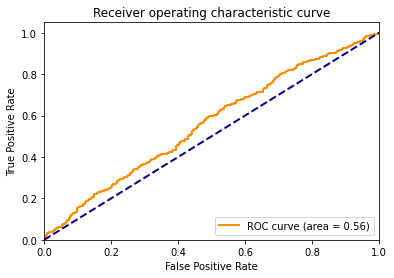

In [119]:
fpr, tpr, _ = roc_curve(valid_labels, preds_dn)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

In [120]:
if SAVE_DN169:
    densenet_model.save('mura_densenet169.h5')